<a href="https://colab.research.google.com/github/rmr327/PdpExplained/blob/main/pdp_explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References

Class lecture: https://canvas.duke.edu/courses/38514/modules/items/342737

Previous work: https://github.com/rmr327/BtcDrivers

I used ChatGPT 3.5 to rephrase some text (also fill in little details with instruction).

I used google gemini for code complettion.

> Loading necessary libraries

In [ ]:
import pandas as pd
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Set the style of seaborn
sns.set_style("darkgrid")

# copy without warnings
pd.options.mode.chained_assignment = None

# Partial Dependence Plots (PDP) with Examples

## Introduction

**What is a PDP?**

>Partial Dependence plots is a tool in Data Science that helps users identify isolated effects from each input feature to a model (holding all other features constant). For example, according to a chosen ML model, if you wanted to know how Bitcoin prices fluctuate in response to bad news (which is the selected feature), a PDP can help.


**Why PDP?**

>Model Interpretation: They help in interpreting complex models by showing the effect of individual features on the prediction.

>Feature Importance: They provide insights into which features are most influential in the model's predictions.

>Transparency: They make the model's decision-making process more transparent and understandable.


**How PDP Works**

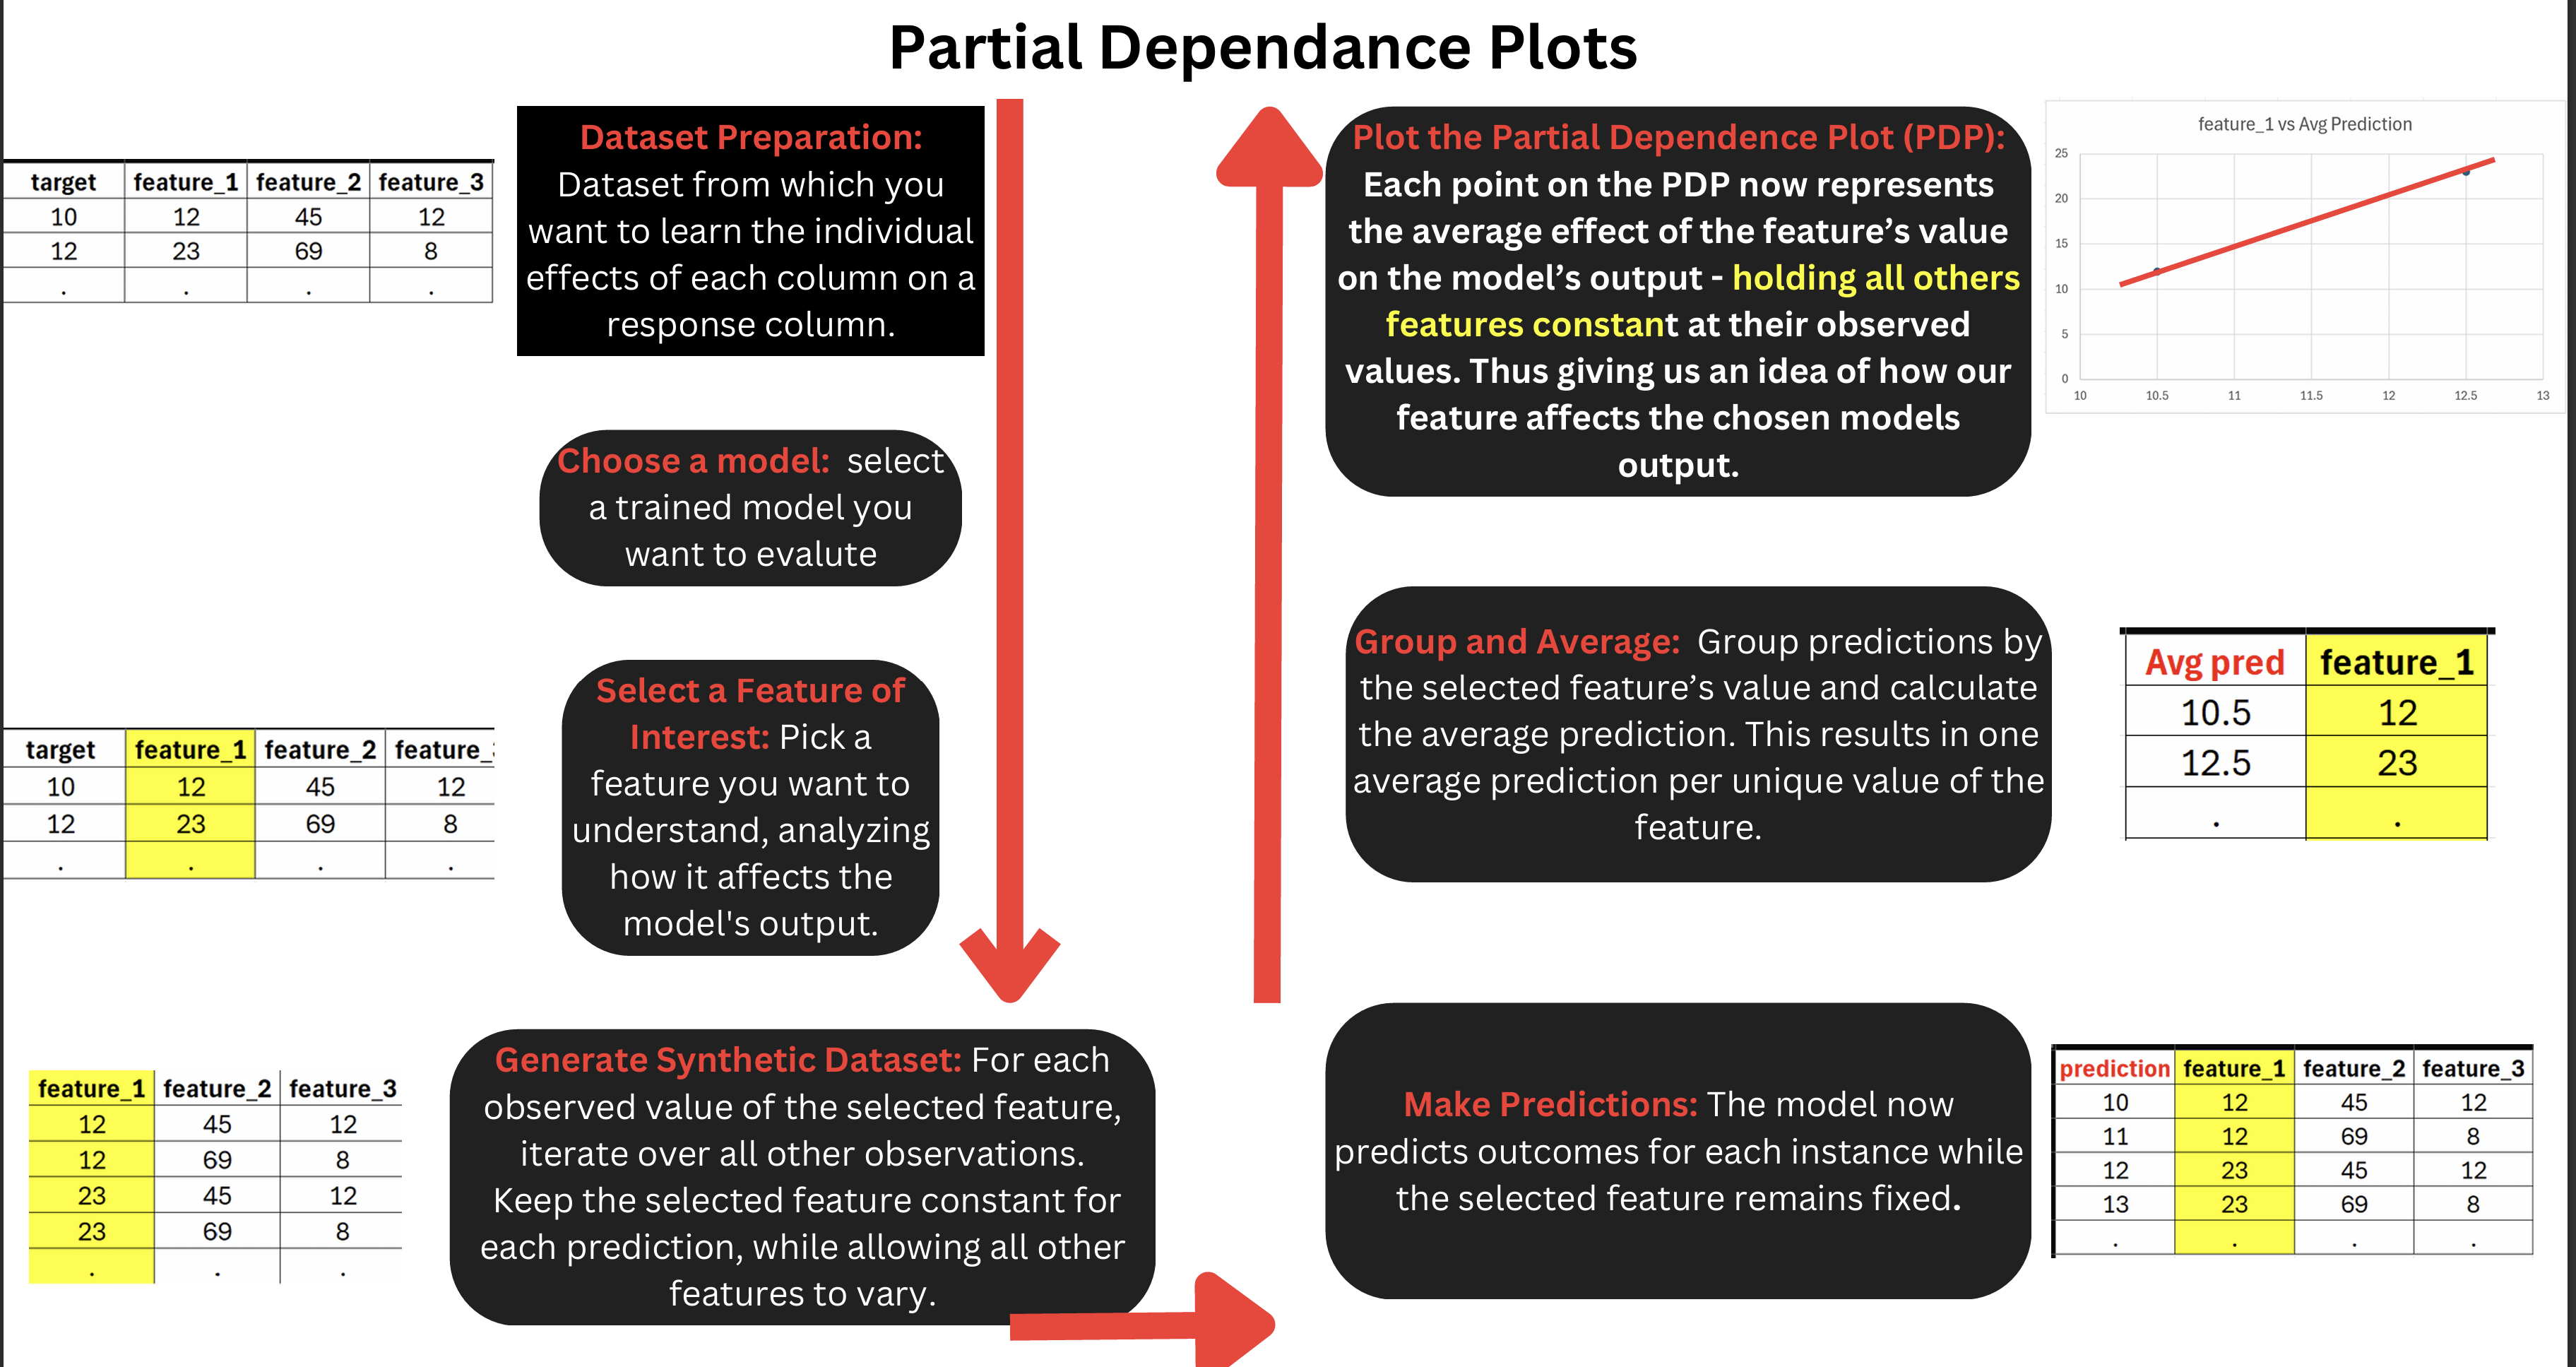

**PDP Limitations**

1) Assumption of Feature Independence

2) When features are correlated, the independence assumption is violated.

3) PDPs are limited in their ability to show interactions between multiple features

4) In high-dimensional data, where there are many features, the assumption of feature independence becomes more problematic.

5) Visual interpretations from PDPs should be done cautiously, especially in the presence of overfitting.

### Mathematical foundation of PDP (From Lecture)

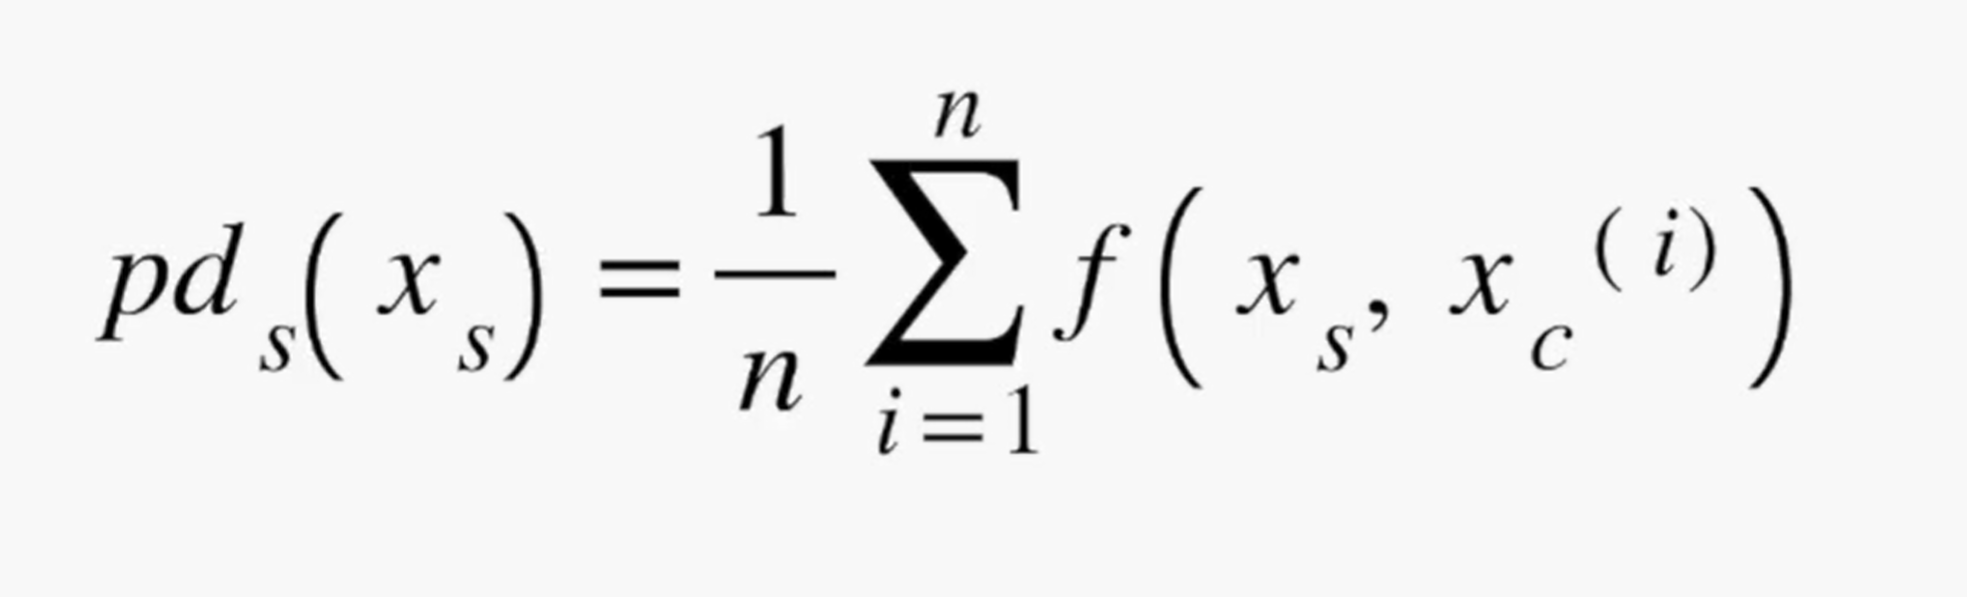

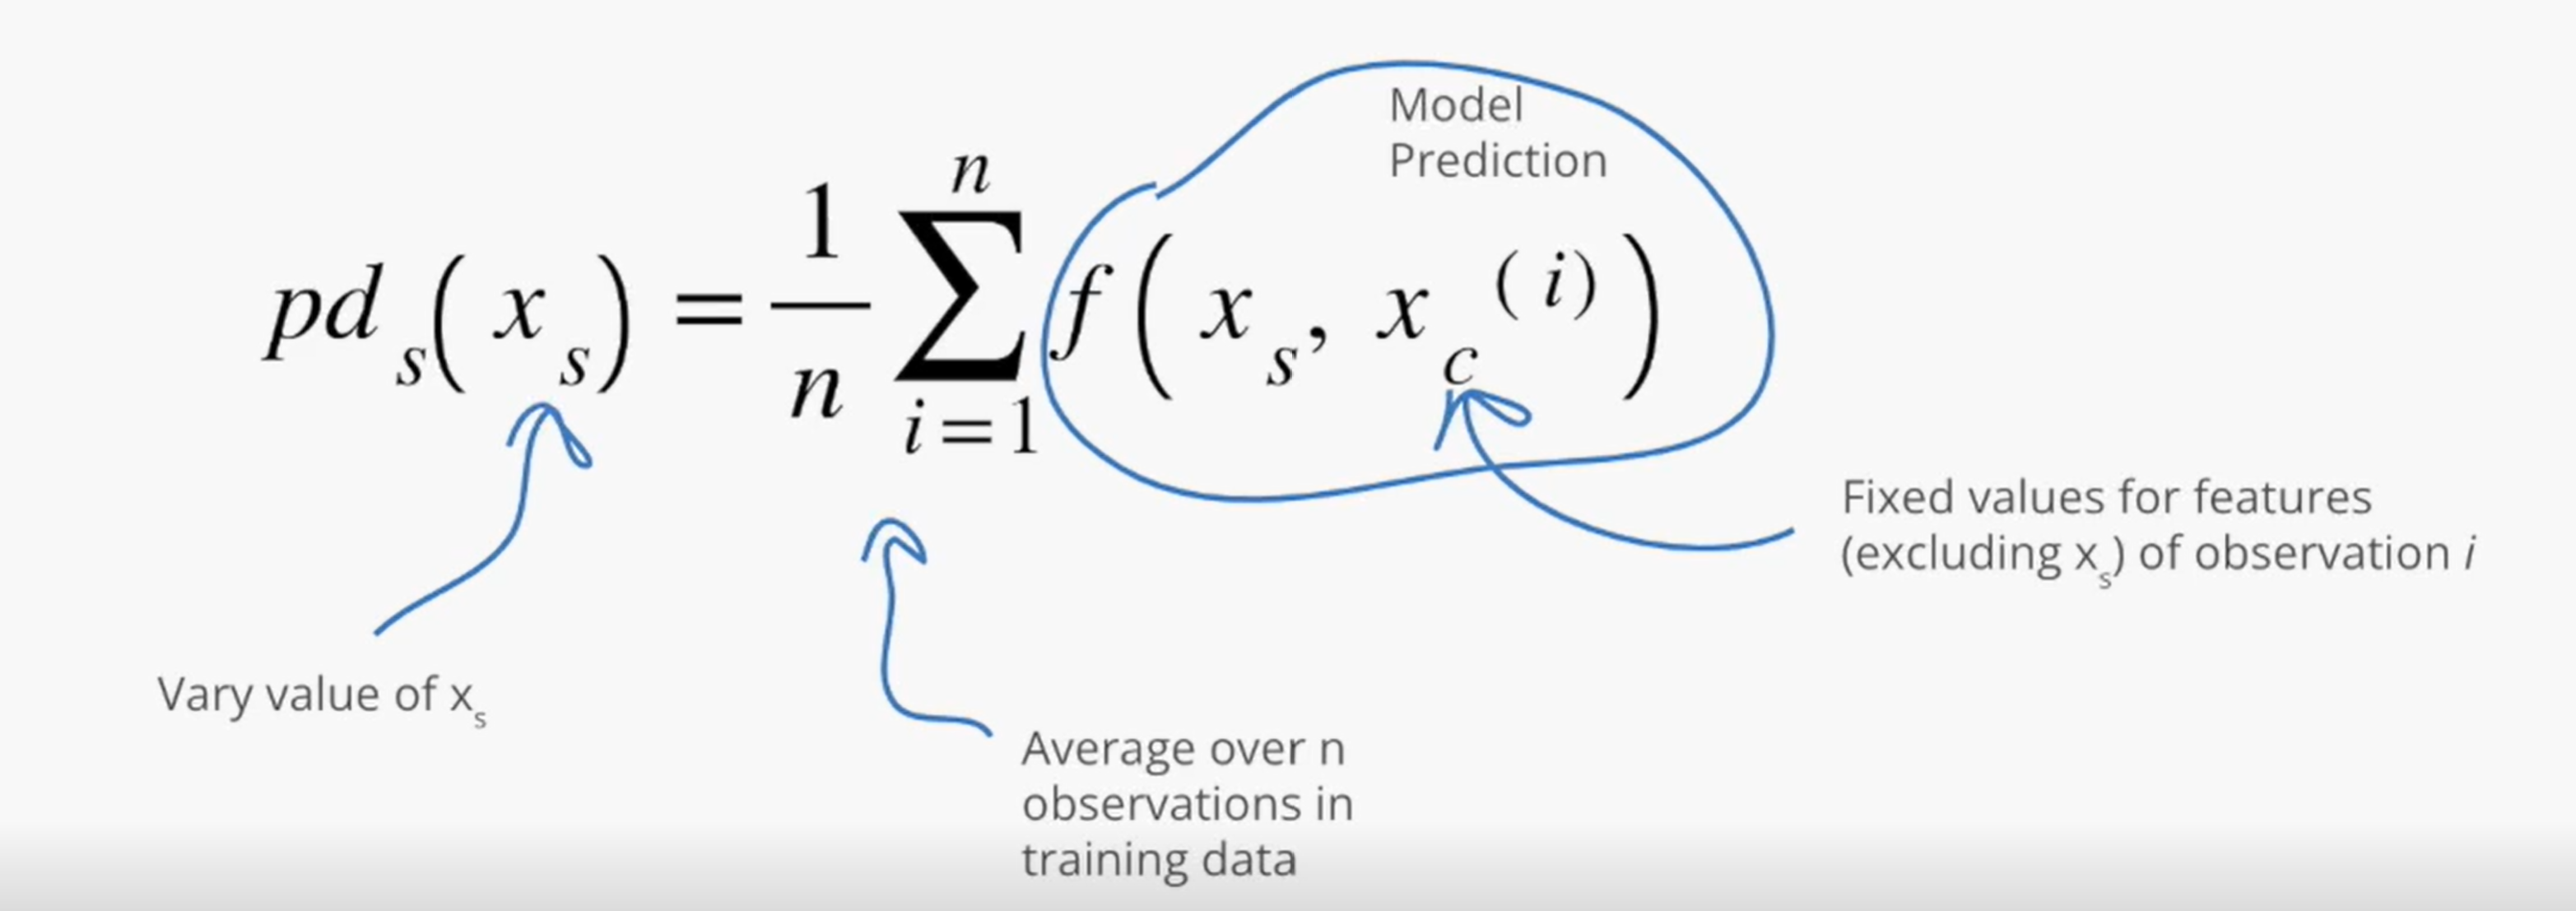

## Code Demo

### **Step 1)** Dataset preperation

In [17]:
data = pd.read_csv(r"https://raw.githubusercontent.com/nogibjj/Flamingo-ML/refs/heads/main/Data/Aggregated_Final_Lin_Rakeen_Fixed_returns.csv")

# drop magnitude and Direction columns
data = data.drop(columns=["magnitude", "Direction"])

# setting datetime as index
data.set_index("date_dt", inplace=True)
data.index = pd.to_datetime(data.index)


# convert return to moving average (Not really needed, but this is our target column)
data["Daily_Return_rolling_15_avg"] = data["Daily Return"].rolling(window=15).mean()
data.dropna(inplace=True)

# drop original return column
data = data.drop(columns=["Daily Return"])

# below we create a lagged version of our dataset for additional features (Think stationary)
# Define the number of lags
n_lags = 3
split_date = "2023-03-01"

# Create a new DataFrame for lagged features
lagged_features = []
lagged_features_cols = []

# dropping the target column since we will predict this below
data = data.dropna(subset=["Daily_Return_rolling_15_avg"])

X_now = data.drop(
    columns=[
        "Daily_Return_rolling_15_avg"
    ]
)
y_now = data["Daily_Return_rolling_15_avg"]

# Create lagged versions of features
for column in X_now.columns:
    for lag in range(1, n_lags + 1):
        lagged_features.append(X_now[column].rolling(lag * 10).sum())
        lagged_features_cols.append(f"{column}_rolling_{lag * 10}")

lagged_features = pd.concat(lagged_features, axis=1)
lagged_features.columns = lagged_features_cols

# Concatenate the original DataFrame with the DataFrame of lagged features
X_now = pd.concat([X_now, lagged_features], axis=1)

# Drop rows with NaN values caused by lagging in both X and y
X_now = X_now.dropna()
y_now = y_now[X_now.index]

# keep only necessary cols (as identified by a previous study)
cols = ['rsi', 'stoch_%D', 'stoch_%K_rolling_10',
 'Relative_Intraday_Price_Change_rolling_10',
 'negative_count_coinbase_rolling_10', 'stoch_%K', 'close_open_rolling_10',
 'stoch_%D_rolling_10', 'Relative_Intraday_Price_Change_rolling_20',
 'T5YIE_rolling_20']

df = X_now[cols]

df.head()

,rsi,stoch_%D,stoch_%K_rolling_10,Relative_Intraday_Price_Change_rolling_10,negative_count_coinbase_rolling_10,stoch_%K,close_open_rolling_10,stoch_%D_rolling_10,Relative_Intraday_Price_Change_rolling_20,T5YIE_rolling_20
date_dt,,,,,,,,,,
2021-06-04,43.454922,58.695895,404.370569,1.628377,36.0,72.924150,371.257812,361.274648,-19.024255,52.40
2021-06-05,39.322872,62.911023,435.357386,-3.340697,32.0,59.311582,-1583.261719,400.204508,-18.799205,52.26
2021-06-06,37.118098,59.165742,439.125116,-9.290390,30.0,45.261493,-3813.035156,426.284357,-21.842813,52.12
2021-06-07,37.983986,45.607042,434.009319,-6.141329,29.0,32.248052,-2609.343750,436.163940,-14.730482,51.94
2021-06-08,34.221218,26.202043,409.972787,-5.192592,26.0,1.096584,-2074.425781,427.702408,-19.747136,51.73


> Find the definitions of the columns used below.

| Feature Name                                   | Definition                                                                         |
|-----------------------------------------------|------------------------------------------------------------------------------------|
| RSI                                           | Relative Strength Index for Bitcoin, a momentum indicator measuring the speed and change of price movements |
| stoch_%D                                      | Stochastic oscillator %D value for Bitcoin |
| stoch_%K_rolling_10                           | Stochastic oscillator %K value for Bitcoin, summed over a rolling 10 day window              |
| Relative_Intraday_Price_Change_rolling_10     | Relative change in intraday price summed over a 10 day rolling window                  |
| stoch_%K                                      | Stochastic oscillator %K value for Bitcoin |
| negative_count_coinbase_rolling_10            | Number of negative news mentions about Coinbase summed over a 10 day rolling window    |
| Relative_Intraday_Price_Change_rolling_10     | Relative change in intraday price summed over a 10-period rolling window                  |
| stoch_%D_rolling_10                           | Stochastic oscillator %D value for Bitcoin, summed over a rolling 10 day window              |
| total_news_score_coinbase_rolling_10          | Aggregate score of news sentiment about Coinbase summed over a 10-period rolling window   |
| close_open_rolling_20                         | Difference between closing and opening prices summed over a 20-period rolling window      |

### **Step 2)** Choose a machine learning model to evaluate

> We will be picking a model I trained in a previous project to predict the movement of Bitcoin prices over the next day.

In [9]:
# lets download the model from my github
!wget -P /content/ https://github.com/rmr327/BtcDrivers/raw/main/model.joblib

--2024-11-14 12:07:43--  https://github.com/rmr327/BtcDrivers/raw/main/model.joblib
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rmr327/BtcDrivers/main/model.joblib [following]
--2024-11-14 12:07:43--  https://raw.githubusercontent.com/rmr327/BtcDrivers/main/model.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5816721 (5.5M) [application/octet-stream]
Saving to: ‘/content/model.joblib’

model.joblib        100%[===================>]   5.55M  --.-KB/s    in 0.09s   

2024-11-14 12:07:44 (62.4 MB/s) - ‘/content/model.joblib’ saved [5816721/5816721]



### **Steps 3, 4, 5, 6)** Select a feature of interest, generate synthetic data by fixing this feature’s value across all observations, and use the chosen model to make predictions on this modified dataset. Finally, group by the fixed feature value and average the predictions to obtain a single prediction for each original feature value. Lastly, plot and see how each individual feature affect our model output, while holding all other features constant.

In [10]:
# Lets load the model from the downloaded joblib file
model = joblib.load(r'/content/model.joblib')

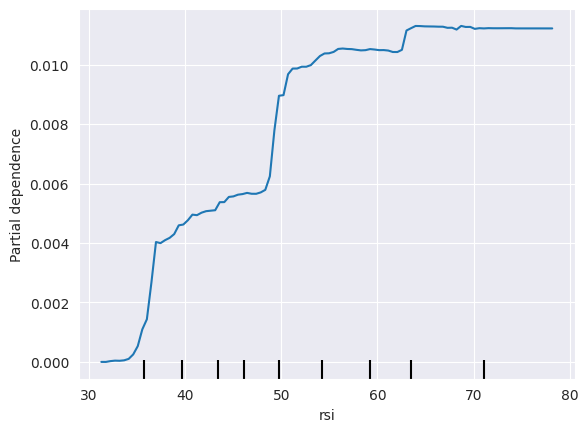

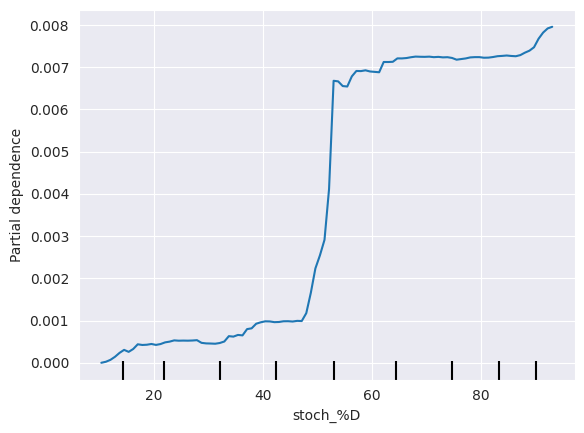

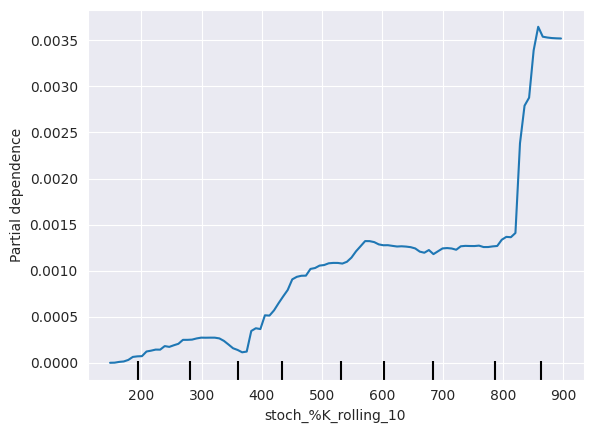

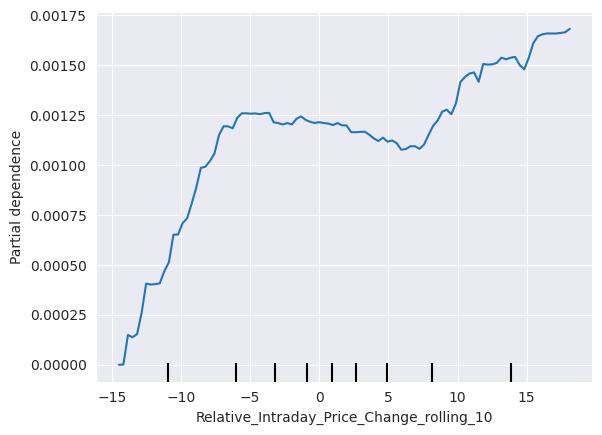

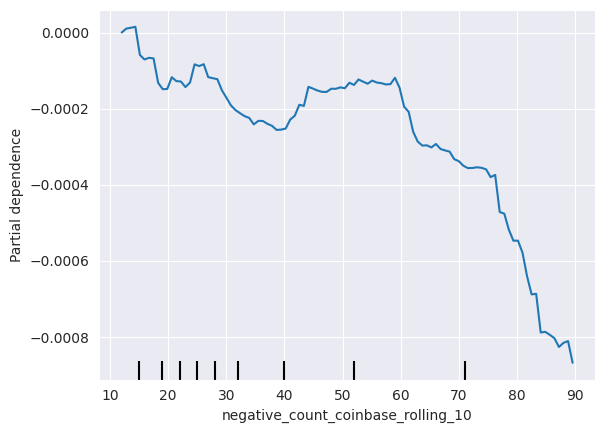

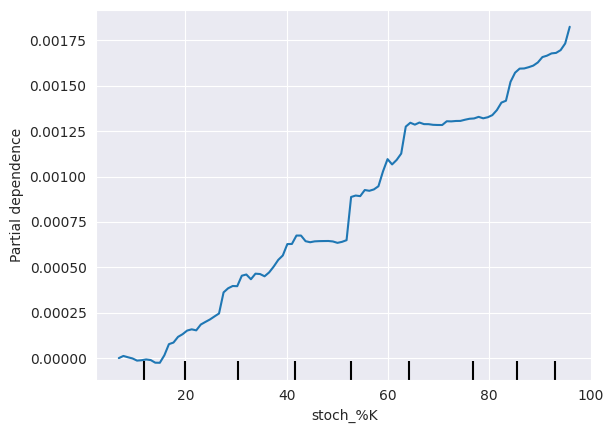

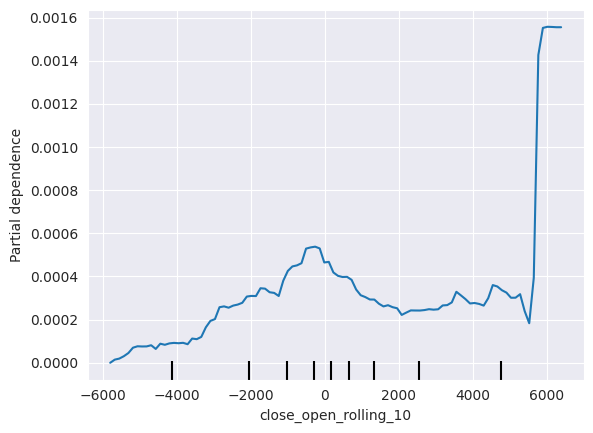

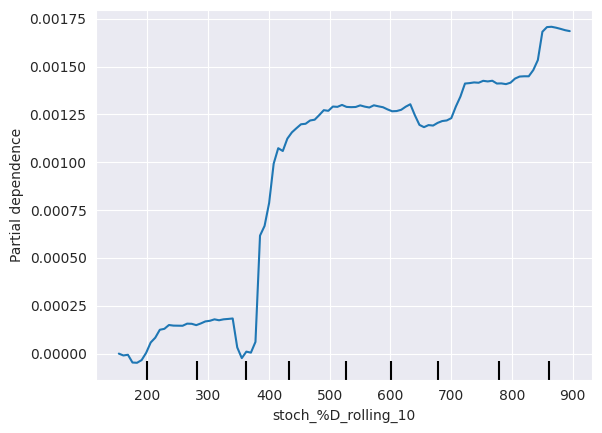

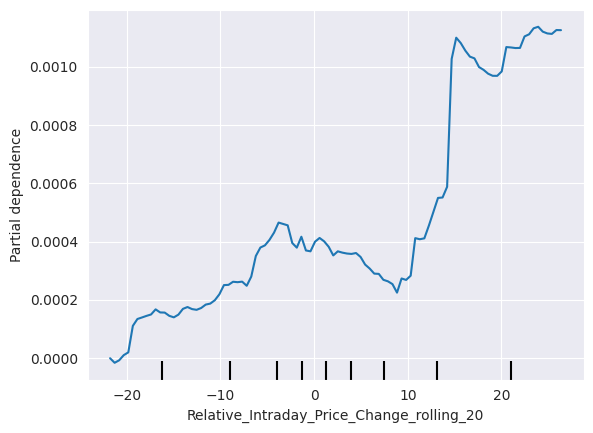

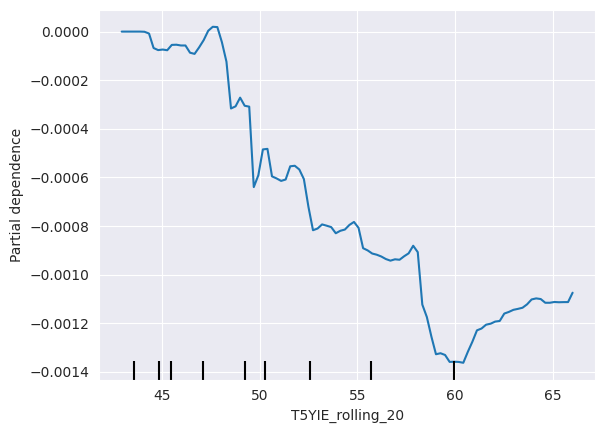

In [19]:
# lets now calculate and plot the PDPs for all of our chosen features
for col in df.columns:
    # Choose the feature of interest
    features = [col]

    # Use PartialDependenceDisplay to display the ICE plot
    PartialDependenceDisplay.from_estimator(model,
                                            df[cols],
                                            features,
                                            centered=True) # Makes it easier to see trend

> Interpretation of PDP plots

> RSI: Based on the PDP plots, there appears to be a correlation where as RSI rises, the price of Bitcoin also tends to increase. However, this presents a problem since RSI traditionally signals overbought and oversold conditions for assets. Ideally, one would anticipate RSI to exert both positive and negative influences on the Bitcoin price.

>STOCH_%d: Based on the PDP plots, there appears to be a inflection point around 50, where bigger values for STOCH%D leads to higher prices for Bitcoin the following day. Similar argument as RSI applies here for unrealistic relationship with BTC price.

>STOCH_%k_rolling_10: Based on the PDP plots, there appears to be a inflection point around 800, where bigger values for STOCH_%k_rolling_10 leads to higher prices for Bitcoin the following day. Similar argument as RSI applies here for unrealistic relationship with BTC price.

>Relative_Intraday_Price_change_rolling_20: Based on the PDP plots, there seems to be very little correlation between this feature and the price of Bitcoin. This finding appears somewhat implausible considering it ranks among our top ten most important features. The observed lack of relationship may be attributed to issues of multicollinearity between the input features.

>STOCH_%d: Same as STOCH_%d

>negative_count_coinbase_rolling_10: According to the PDP plots, there appears to be an inverse relationship between this variable and the prediction of Bitcoin price. This aligns with common sense, as one would anticipate a decline in Bitcoin price corresponding to an increase in negative news coverage about Coinbase, a prominent cryptocurrency exchange.

>close_open_rolling_20: Same as relative_Intraday_Price_change_rolling_20

>STOCH_%D_rolling_10: Same as STOCH_%K_rolling_10

>total_news_score_coinbase_rolling_10: This feature has minimal impact (in terms of magnitue) on the price of the model's Bitcoin prediction.

## Conclusion

From the partial dependence plots above, we are able to get a good insight on how each of our features affect our model's predictions. We also notice that features that are correlated in our model leads to a less dependable PDP. ALE plots may be explored for features that are correlated.